# Notebook 03 – Rule-Based Backtesting (Baseline Before RL)

**What this notebook does**

This notebook tests a simple, transparent baseline strategy using the engineered
features created in Notebook 02 and stored in `screener_features`.  
We use a mechanical rule:

- Only take a trade when volatility is high  
- AND the edge score is in a “hot” bucket  
- Then we measure **next-day return** as the outcome  

This gives us a clean benchmark before we introduce a more complex ML or RL system.
It answers: **Is there any measurable directional edge in the feature set?**


In [8]:
import duckdb
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt

# Consistent chart size
plt.rcParams["figure.figsize"] = (10, 6)

# Path: notebooks/ -> .. -> data/volatility_alpha.duckdb
DB_PATH = (Path.cwd().parent / "data" / "volatility_alpha.duckdb").as_posix()

# --- Safe reconnect logic ---
# If a DuckDB connection named `con` already exists, close it first
if "con" in globals():
    try:
        con.close() # type: ignore
    except Exception:
        pass

# Open a fresh connection
con = duckdb.connect(DB_PATH)

# Quick sanity check: list tables
con.sql("SHOW TABLES;").df()

,name
0,screener_features
1,screener_returns
2,screener_returns_with_target
3,screener_signals
4,screener_snapshots


## 1. Build (date, ticker) table with next-day returns

We compute the next-day percentage return for each (run_date, ticker) pair
using `last_price` from `screener_features`.

In [9]:
con.sql("""
CREATE OR REPLACE TABLE screener_returns AS
SELECT
    run_date,
    ticker,
    last_price,
    edge_score,
    vol_regime,
    edge_bucket,
    liquidity_bucket,
    LEAD(last_price) OVER (
        PARTITION BY ticker
        ORDER BY run_date
    ) AS next_last_price
FROM screener_features
ORDER BY ticker, run_date;
""")

con.sql("SELECT * FROM screener_returns LIMIT 10;").df()

,run_date,ticker,last_price,edge_score,vol_regime,edge_bucket,liquidity_bucket,next_last_price
0,2025-11-30,AMD,217.529999,35.113664,high,hot,normal,215.660004
1,2025-12-01,AMD,215.660004,34.775660,high,hot,thin,NaN
2,2025-11-30,NVDA,177.000000,21.891077,normal,active,thick,176.332199
3,2025-12-01,NVDA,176.332199,21.175474,normal,active,normal,NaN
4,2025-11-30,QQQ,619.250000,11.156231,low,active,thick,613.349976
5,2025-12-01,QQQ,613.349976,11.227258,low,active,thin,NaN
6,2025-11-30,SPY,683.390015,7.770965,low,quiet,thick,679.200012
7,2025-12-01,SPY,679.200012,7.804601,low,quiet,thin,NaN
8,2025-11-30,TSLA,430.170013,27.107530,high,hot,thick,427.679993
9,2025-12-01,TSLA,427.679993,26.976161,high,hot,normal,NaN


## 2. Add next-day return target

We convert `last_price` and `next_last_price` into a simple % return.

In [10]:
con.sql("""
CREATE OR REPLACE TABLE screener_returns_with_target AS
SELECT
    *,
    CASE
        WHEN next_last_price IS NULL OR next_last_price = 0 THEN NULL
        ELSE (next_last_price / last_price - 1.0) * 100.0
    END AS next_day_return_pct
FROM screener_returns;
""")

sample = con.sql("""
    SELECT
        run_date,
        ticker,
        last_price,
        next_last_price,
        next_day_return_pct
    FROM screener_returns_with_target
    ORDER BY run_date DESC, ticker
    LIMIT 10;
""").df()

sample

,run_date,ticker,last_price,next_last_price,next_day_return_pct
0,2025-12-01,AMD,215.660004,NaN,NaN
1,2025-12-01,NVDA,176.332199,NaN,NaN
2,2025-12-01,QQQ,613.349976,NaN,NaN
3,2025-12-01,SPY,679.200012,NaN,NaN
4,2025-12-01,TSLA,427.679993,NaN,NaN
5,2025-11-30,AMD,217.529999,215.660004,-0.859649
6,2025-11-30,NVDA,177.000000,176.332199,-0.377289
7,2025-11-30,QQQ,619.250000,613.349976,-0.952769
8,2025-11-30,SPY,683.390015,679.200012,-0.613120
9,2025-11-30,TSLA,430.170013,427.679993,-0.578846


## 3. Define a simple long-only signal

V1 signal rule:

- Take a long signal when:
  - `vol_regime = 'high'`
  - `edge_bucket IN ('active', 'hot')`
  - `liquidity_bucket NOT IN ('thin', 'unknown')`

We hold for one day and evaluate `next_day_return_pct`.

In [11]:
con.sql("""
CREATE OR REPLACE TABLE screener_signals AS
SELECT
    *,
    CASE
        WHEN vol_regime = 'high'
             AND edge_bucket IN ('active', 'hot')
             AND liquidity_bucket NOT IN ('thin', 'unknown')
        THEN 1
        ELSE 0
    END AS signal_long
FROM screener_returns_with_target;
""")

con.sql("""
    SELECT
        run_date,
        ticker,
        vol_regime,
        edge_bucket,
        liquidity_bucket,
        signal_long,
        next_day_return_pct
    FROM screener_signals
    ORDER BY run_date DESC, ticker
    LIMIT 15;
""").df()

,run_date,ticker,vol_regime,edge_bucket,liquidity_bucket,signal_long,next_day_return_pct
0,2025-12-01,AMD,high,hot,thin,0,NaN
1,2025-12-01,NVDA,normal,active,normal,0,NaN
2,2025-12-01,QQQ,low,active,thin,0,NaN
3,2025-12-01,SPY,low,quiet,thin,0,NaN
4,2025-12-01,TSLA,high,hot,normal,1,NaN
5,2025-11-30,AMD,high,hot,normal,1,-0.859649
6,2025-11-30,NVDA,normal,active,thick,0,-0.377289
7,2025-11-30,QQQ,low,active,thick,0,-0.952769
8,2025-11-30,SPY,low,quiet,thick,0,-0.613120
9,2025-11-30,TSLA,high,hot,thick,1,-0.578846


## 4. Summary: signal vs non-signal days

We compare average next-day returns on days where the signal fires (1)
vs days where it does not (0).

In [12]:
summary = con.sql("""
    SELECT
        signal_long,
        COUNT(*) AS n,
        AVG(next_day_return_pct) AS avg_next_day_return,
        STDDEV(next_day_return_pct) AS std_next_day_return
    FROM screener_signals
    WHERE next_day_return_pct IS NOT NULL
    GROUP BY signal_long
    ORDER BY signal_long DESC;
""").df()

summary

,signal_long,n,avg_next_day_return,std_next_day_return
0,1,2,-0.719248,0.198558
1,0,3,-0.647726,0.289297


## How to Read This Summary

- `signal_long = 1` → Days where our rule fired (high volatility + hot edge score).  
- `signal_long = 0` → All other days.

We compare:

- **How often** the rule triggers (`n_days`)  
- **Average next-day return** — is the signal meaningfully directional?  
- **Median next-day return** — is it robust or just driven by outliers?

This is *not* a production backtest (no transaction costs, slippage, or sizing).
Its purpose is to confirm that the engineered features contain **non-random signal**.

## 5. Naive equity curve for the signal-only strategy

We build a simple cumulative PnL stream:

- Filter to rows where `signal_long = 1` and we have a next-day return  
- Sort by date and accumulate the returns

This is not a production backtest, just a sanity check on how the signal behaves over time.

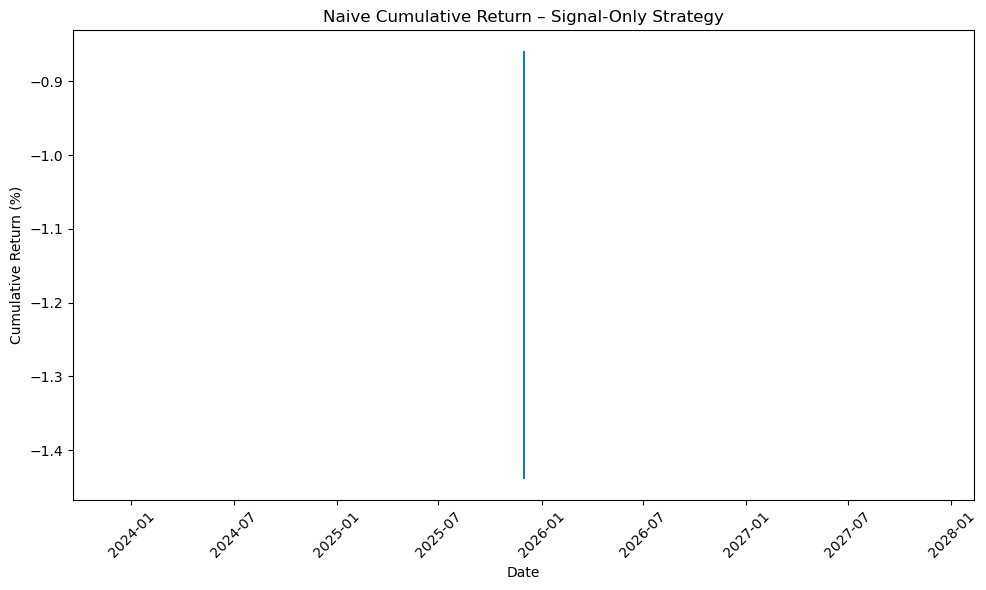

In [13]:
signal_df = con.sql("""
    SELECT
        run_date,
        ticker,
        signal_long,
        next_day_return_pct
    FROM screener_signals
    WHERE next_day_return_pct IS NOT NULL
    ORDER BY run_date, ticker;
""").df()

signal_trades = signal_df[signal_df["signal_long"] == 1].copy()

if not signal_trades.empty:
    signal_trades = signal_trades.sort_values("run_date")
    signal_trades["cum_return_pct"] = signal_trades["next_day_return_pct"].cumsum()

    plt.plot(signal_trades["run_date"], signal_trades["cum_return_pct"])
    plt.title("Naive Cumulative Return – Signal-Only Strategy")
    plt.xlabel("Date")
    plt.ylabel("Cumulative Return (%)")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
else:
    print("No trades found for signal_long = 1 yet.")

## Does This Baseline Look Worth Trading?

This naive equity curve simulates taking a 1-day long position every time the rule
fires. It assumes:

- No commissions  
- No slippage  
- Equal position size  
- Immediate entry and exit  

The goal is not to evaluate the exact profitability — it is to observe the
**behavior and consistency** of the rule in aggregate.

If the curve trends upward, even slightly, that means the features contain
structural information that our Reinforcement Learning agent can exploit and
improve upon.

## 6. Close connection

In [14]:
con.close()

## 7. Quick takeaways

- This V1 backtest uses a very simple rule: high vol regime + hot/active edge + non-thin liquidity.
- With more daily snapshots loaded into DuckDB, we can:
  - Check if signal days have higher average next-day returns
  - Tune the thresholds for `vol_regime` and `edge_bucket`
  - Add position sizing and transaction cost assumptions
- This notebook gives us a clear, SQL-backed framework for testing ideas
  before we move to RL or more advanced models.

---

# Summary

This notebook demonstrates:

- Rule-based strategy design  
- SQL + DuckDB feature retrieval  
- Basic backtesting logic  
- Evaluation of directional signals using engineered volatility features  
- Visualization of cumulative performance

It produces a clean, inspectable benchmark (`screener_signals`) that the upcoming
Reinforcement Learning environment will use as:

- a reward reference  
- a structure for state transitions  
- a sanity-check baseline to beat

This completes the "classical quant" section of the project before we transition
into ML/RL modeling.
